In [1]:
import itertools
import warnings

import numpy as np
import pandas as pd
import statsmodels.api as sm

from matplotlib import pyplot as plt

import math
import datetime

from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

from pylab import rcParams
import statsmodels.api as sm
import statsmodels

import seaborn as sns

plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_excel("C:/Users/hayrettin.sipar/Desktop/Projeler/Pladis/Bisküvi Talep Tahminleme/Input Data/Sales History/Sales Forecast Data v8.xlsx",
                   sheet_name='Sales_History',header=0)

In [3]:
cal_monthly = pd.read_excel("C:/Users/hayrettin.sipar/Desktop/Projeler/Pladis/Bisküvi Talep Tahminleme/Input Data/Sales History/Sales Forecast Data v8.xlsx",
                   sheet_name='Calendar_Monthly',header=0)

In [4]:
grp = pd.read_excel("C:/Users/hayrettin.sipar/Desktop/Projeler/Pladis/Bisküvi Talep Tahminleme/Input Data/Advertisement/GRP_All.xlsx",
                   sheet_name='GRP_SOV_PROD',header=0)

In [5]:
grp = grp[['Brand','Product','GRP_30','Date']]

In [6]:
df_all = pd.merge(left=df,right=cal_monthly,left_on='MONTH',right_on='DATE').drop(labels=['Weighteddist','Numericdist','DATE'],axis=1)

In [7]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422212 entries, 0 to 422211
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Mkt_Group              422212 non-null  object 
 1   Mkt                    422212 non-null  object 
 2   Prod                   422212 non-null  object 
 3   Mainsegment            422212 non-null  object 
 4   Segment                422212 non-null  object 
 5   Company                422212 non-null  object 
 6   Brand                  422212 non-null  object 
 7   Subbrand               422212 non-null  object 
 8   MONTH                  422212 non-null  object 
 9   Sales_vol              422212 non-null  float64
 10  Sales_val              422212 non-null  float64
 11  Ppv                    422212 non-null  float64
 12  No_of_days             422212 non-null  int64  
 13  Weekdays_n             422212 non-null  int64  
 14  Weekdays_Ratio         422212 non-nu

In [8]:
df_all.MONTH = df_all.MONTH.apply(lambda x: datetime.datetime.strptime(x, '%b %Y'))
df_all.index = df_all.MONTH
df_all.rename(columns={'MONTH':'DATE'},inplace=True)

In [9]:
grp.Date = grp.Date.apply(lambda x: datetime.datetime.strptime(x, '%b %Y'))
grp.index = grp.Date
#grp.rename(columns={'MONTH':'DATE'},inplace=True)

In [10]:
df_all.index = pd.to_datetime(df_all.index)
grp.index = pd.to_datetime(grp.index)

In [11]:
df_all.sort_values(by=['Mkt_Group','Mkt','Mainsegment','Segment','Company','Brand','Subbrand','DATE'],inplace=True)

In [12]:
df_biskrem = df_all[df_all['Subbrand'] == 'BISKREM']
grp_biskrem = grp[grp['Product']=='BISKREM']

In [13]:
agg_func = {'DATE':['max'],'Sales_vol':['sum'],'No_of_days':['max'],'Actual_Holiday_Ratio':['max'],
            'School_Day_Ratio':'max','Ramadan_Ratio':'max','Pandemic':'max'}

df_biskrem_agg = df_biskrem.groupby('DATE').agg(agg_func)

In [14]:
df_biskrem_agg

,DATE,Sales_vol,No_of_days,Actual_Holiday_Ratio,School_Day_Ratio,Ramadan_Ratio,Pandemic
,max,sum,max,max,max,max,max
DATE,,,,,,,
2016-12-01,2016-12-01,614.6,31,0.2903,0.7097,0.0000,0
2017-01-01,2017-01-01,643.2,31,0.2903,0.4839,0.0000,0
2017-02-01,2017-02-01,688.2,28,0.2857,0.6071,0.0000,0
2017-03-01,2017-03-01,799.7,31,0.2581,0.7419,0.0000,0
2017-04-01,2017-04-01,774.8,30,0.3333,0.6667,0.0000,0
2017-05-01,2017-05-01,781.8,31,0.3226,0.6774,0.1613,0
2017-06-01,2017-06-01,610.4,30,0.3333,0.2333,0.8000,0
2017-07-01,2017-07-01,573.1,31,0.3226,0.0000,0.0000,0


In [15]:
rename_list = ['DATE','Sales_vol','No_of_days','Actual_Holiday_Ratio','School_Day_Ratio','Ramadan_Ratio','Pandemic']

df_biskrem_agg.columns = rename_list

df_biskrem_agg['Sales_vol_daily'] = df_biskrem_agg.Sales_vol / df_biskrem_agg.No_of_days

In [16]:
df_biskrem_agg.index = pd.date_range(df_biskrem_agg['DATE'].iloc[0], periods=45, freq='M')

In [17]:
grp_biskrem.index = pd.date_range(grp_biskrem['Date'].iloc[0], periods=45, freq='M')

In [18]:
grp_biskrem.index

DatetimeIndex(['2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
               '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31',
               '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31',
               '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30',
               '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
               '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31',
               '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
               '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31'],
              dtype='datetime64[ns]', freq='M')

In [19]:
df_biskrem_agg.index

DatetimeIndex(['2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
               '2017-12-31', '2018-01-31', '2018-02-28', '2018-03-31',
               '2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31',
               '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30',
               '2018-12-31', '2019-01-31', '2019-02-28', '2019-03-31',
               '2019-04-30', '2019-05-31', '2019-06-30', '2019-07-31',
               '2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
               '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31'],
              dtype='datetime64[ns]', freq='M')

In [20]:
df_biskrem_agg.drop('DATE',axis=1,inplace=True)

In [21]:
grp_biskrem.drop('Date',axis=1,inplace=True)

C:\Users\hayrettin.sipar\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [22]:
df_biskrem_all = pd.merge(df_biskrem_agg,grp_biskrem,left_index=True,right_index=True).copy()

In [23]:
df_biskrem_all

,Sales_vol,No_of_days,Actual_Holiday_Ratio,School_Day_Ratio,Ramadan_Ratio,Pandemic,Sales_vol_daily,Brand,Product,GRP_30
2016-12-31,614.6,31,0.2903,0.7097,0.0000,0,19.825806,ULKER,BISKREM,0.000000
2017-01-31,643.2,31,0.2903,0.4839,0.0000,0,20.748387,ULKER,BISKREM,234.235000
2017-02-28,688.2,28,0.2857,0.6071,0.0000,0,24.578571,ULKER,BISKREM,291.684667
2017-03-31,799.7,31,0.2581,0.7419,0.0000,0,25.796774,ULKER,BISKREM,261.858000
2017-04-30,774.8,30,0.3333,0.6667,0.0000,0,25.826667,ULKER,BISKREM,132.450000
2017-05-31,781.8,31,0.3226,0.6774,0.1613,0,25.219355,ULKER,BISKREM,0.000000
2017-06-30,610.4,30,0.3333,0.2333,0.8000,0,20.346667,ULKER,BISKREM,0.000000
2017-07-31,573.1,31,0.3226,0.0000,0.0000,0,18.487097,ULKER,BISKREM,0.000000
2017-08-31,650.5,31,0.3065,0.0000,0.0000,0,20.983871,ULKER,BISKREM,244.126000
2017-09-30,692.1,30,0.4167,0.2833,0.0000,0,23.070000,ULKER,BISKREM,271.280667


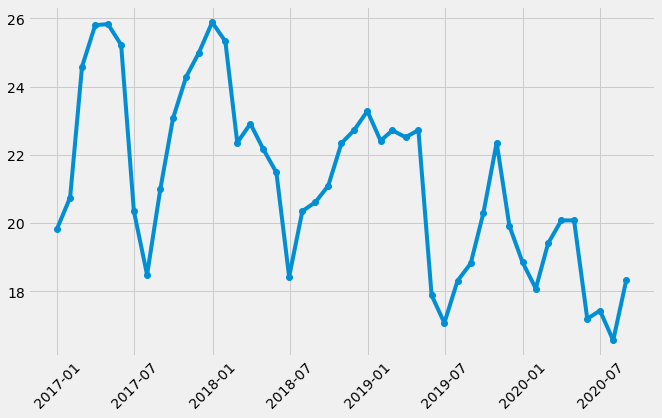

In [24]:
plt.figure(figsize=(10,6))
plt.xticks(rotation=45)
plt.plot(df_biskrem_all['Sales_vol_daily'],marker="o")

In [25]:
cal_tes = cal_monthly[['DATE','No_of_days','Actual_Holiday_Ratio','School_Day_Ratio','Ramadan_Ratio','Pandemic']].copy()

In [26]:
cal_tes.index = cal_tes.DATE
cal_tes.rename(columns={'MONTH':'DATE'},inplace=True)

In [27]:
cal_tes.index = pd.to_datetime(cal_tes.index)
cal_tes.index = pd.date_range(cal_tes['DATE'].iloc[0], periods=85, freq='M')

In [67]:
cal_tes = cal_tes['2020-09-30':'2021-08-31'].copy()
cal_tes['Sales_vol'] = np.NaN
cal_tes['Sales_vol_daily']=np.NaN

col_order= ['Sales_vol','Sales_vol_daily','No_of_days','Actual_Holiday_Ratio','School_Day_Ratio','Ramadan_Ratio','Pandemic']

cal_tes =  cal_tes[col_order]

In [29]:
df_biskrem_all = df_biskrem_all.append(cal_tes).copy()

In [30]:
df_biskrem_all

,Sales_vol,No_of_days,Actual_Holiday_Ratio,School_Day_Ratio,Ramadan_Ratio,Pandemic,Sales_vol_daily,Brand,Product,GRP_30
2016-12-31,614.6,31,0.2903,0.7097,0.0000,0,19.825806,ULKER,BISKREM,0.000000
2017-01-31,643.2,31,0.2903,0.4839,0.0000,0,20.748387,ULKER,BISKREM,234.235000
2017-02-28,688.2,28,0.2857,0.6071,0.0000,0,24.578571,ULKER,BISKREM,291.684667
2017-03-31,799.7,31,0.2581,0.7419,0.0000,0,25.796774,ULKER,BISKREM,261.858000
2017-04-30,774.8,30,0.3333,0.6667,0.0000,0,25.826667,ULKER,BISKREM,132.450000
2017-05-31,781.8,31,0.3226,0.6774,0.1613,0,25.219355,ULKER,BISKREM,0.000000
2017-06-30,610.4,30,0.3333,0.2333,0.8000,0,20.346667,ULKER,BISKREM,0.000000
2017-07-31,573.1,31,0.3226,0.0000,0.0000,0,18.487097,ULKER,BISKREM,0.000000
2017-08-31,650.5,31,0.3065,0.0000,0.0000,0,20.983871,ULKER,BISKREM,244.126000
2017-09-30,692.1,30,0.4167,0.2833,0.0000,0,23.070000,ULKER,BISKREM,271.280667


In [31]:
df_biskrem_all['Brand'].fillna(value='ULKER',inplace=True)
df_biskrem_all['Product'].fillna(value='BISKREM',inplace=True)
df_biskrem_all['GRP_30'].fillna(value=0,inplace=True)

In [33]:
df_biskrem_all.index = pd.date_range('2016-12-31', periods=57, freq='M')

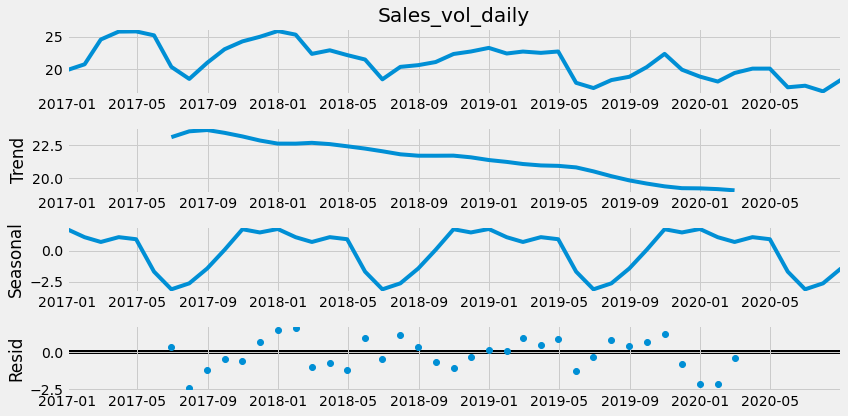

In [34]:
rcParams['figure.figsize'] = 12, 6

decomposition = sm.tsa.seasonal_decompose(df_biskrem_all['Sales_vol_daily'].dropna(),model='additive')
fig = decomposition.plot()

In [35]:
#train_test_split
tr_start,tr_end = '2016-12-31','2020-02-29'
te_start,te_end = '2020-03-31','2021-08-31'

tr_start_pand,tr_end_pand = '2016-12-31','2020-05-31'
te_start_pand,te_end_pand = '2020-06-30','2021-08-31'

tra = df_biskrem_all[tr_start:tr_end]
tes = df_biskrem_all[te_start:te_end]

tra_pand = df_biskrem_all[tr_start_pand:tr_end_pand]
tes_pand = df_biskrem_all[te_start_pand:te_end_pand]

In [36]:
adfres = sm.tsa.adfuller(tra['Sales_vol_daily'],regression='ct')
#adfres2 = sm.tsa.adfuller(tra['Sales_vol'].diff()[1:],regression='ct')

adfres

(-3.761870274909317,
 0.018592807432279788,
 8,
 30,
 {'1%': -4.2970953703703705,
  '5%': -3.5685571851851847,
  '10%': -3.2184266666666668},
 100.75216773456202)

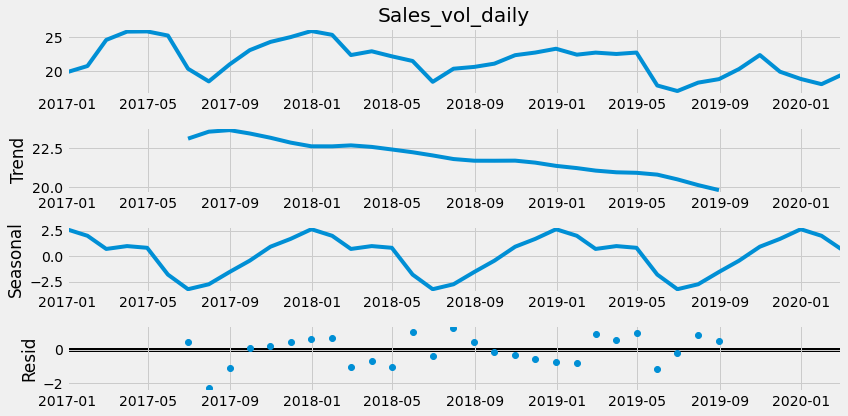

In [37]:
rcParams['figure.figsize'] = 12, 6

decomposition = sm.tsa.seasonal_decompose(tra['Sales_vol_daily'].dropna(),model='additive')
fig = decomposition.plot()

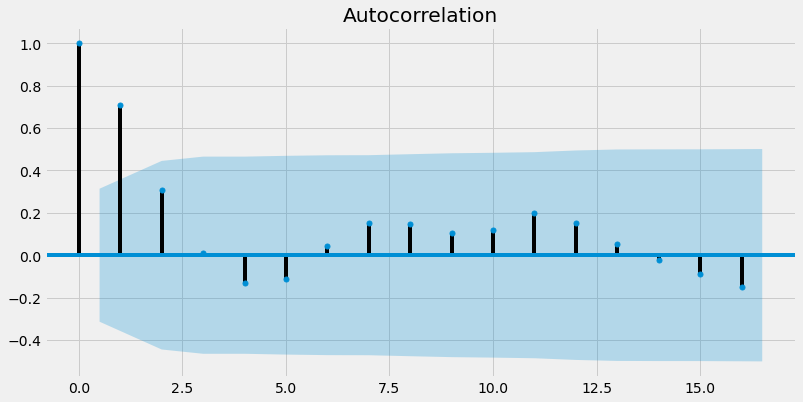

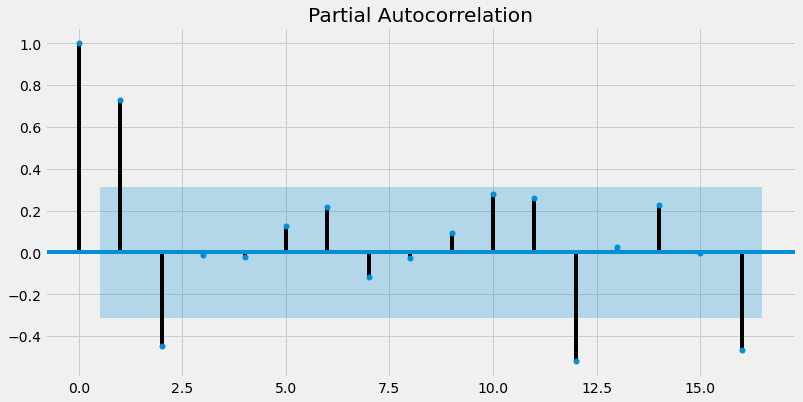

In [38]:
fig = sm.graphics.tsa.plot_acf(tra['Sales_vol_daily'])
fig = sm.graphics.tsa.plot_pacf(tra['Sales_vol_daily'])

In [39]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [40]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

regressors = ['No_of_days','Actual_Holiday_Ratio','School_Day_Ratio','Ramadan_Ratio','GRP_30']


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(tra['Sales_vol_daily'],
                                            tra[regressors],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            trend='t')

            results = mod.fit()

            print('ARIMA{}x{}12 - MAPE:{}'.format(param, param_seasonal, results.aic))
            
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - MAPE:141.49704349415902
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - MAPE:890.6744038371913
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - MAPE:52.358135017195394
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - MAPE:118.19766973334104
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - MAPE:63.13946338450727
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - MAPE:-0.44822534131778013
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - MAPE:80.57956510895991
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - MAPE:3.4785204087972676
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - MAPE:18.0
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - MAPE:91.43929343216776
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - MAPE:96.93278415825036
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - MAPE:61.08764536535727
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - MAPE:66.73430727612231
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - MAPE:64.85230341981861
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - MAPE:8.476589614071344
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - MAPE:-13.00032235914091
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - MAPE:-1.9647891158025068
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - MAPE:20.0
ARIMA(0,

In [41]:
#(2,1,2)x(1,0,0,12) with trend = 't'
#
#
#

regressors = ['No_of_days','Actual_Holiday_Ratio','School_Day_Ratio','Ramadan_Ratio','GRP_30']

mod = sm.tsa.statespace.SARIMAX(tra['Sales_vol_daily'],
                                tra[regressors],
                                order=(2, 1, 2),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                trend='t')

results = mod.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                     Sales_vol_daily   No. Observations:                   39
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 12)   Log Likelihood                 -27.856
Date:                             Tue, 06 Oct 2020   AIC                             79.712
Time:                                     13:36:44   BIC                             93.848
Sample:                                 12-31-2016   HQIC                            83.462
                                      - 02-29-2020                                         
Covariance Type:                               opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
drift                   -0.0070      0.005     -1.522      0.128      -0.016       0.002
No_of_days               0.1928      0.202      0.952      0.341      -0.204       0.590
Actual_Holiday_Ratio     0.6696      2.984      0.224      0.822      -5.178       6.517
School_Day_Ratio         4.0051      0.961      4.167      0.000       2.121       5.889
Ramadan_Ratio           -3.1565      1.008     -3.130      0.002      -5.133      -1.180
GRP_30                   0.0011      0.001      0.795      0.426      -0.002       0.004
ar.L1                   -0.0695      0.471     -0.148      0.883      -0.992       0.853
ar.L2                    0.0119      0.090      0.133      0.894      -0.164       0.188
ma.L1                   -0.3024      2.009     -0.151      0.880      -4.240       3.636
ma.L2                   -0.7233      1.639     -0.441      0.659      -3.936       2.490
ar.S.L12                -0.2736      0.258     -1.060      0.289      -0.780       0.232
sigma2                   0.5139      1.200      0.428      0.668      -1.837       2.865
===================================================================================
Ljung-Box (Q):                       18.69   Jarque-Bera (JB):                 0.89
Prob(Q):                              0.72   Prob(JB):                         0.64
Heteroskedasticity (H):               1.59   Skew:                            -0.47
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
results.resid.describe()

count    39.000000
mean      0.503660
std       2.141593
min      -3.646694
25%      -0.367347
50%       0.334576
75%       1.009544
max      10.812068
dtype: float64

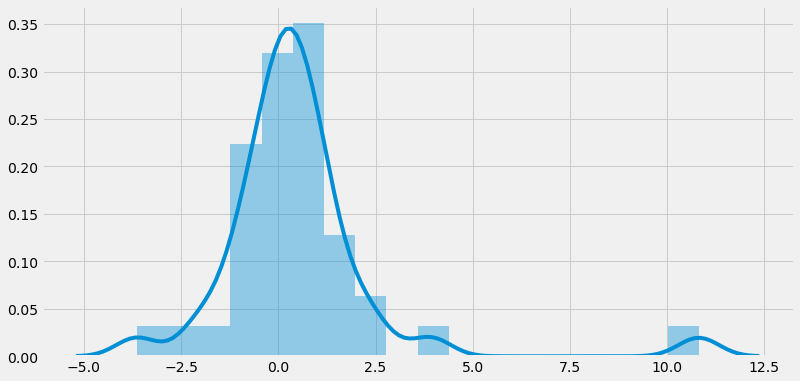

In [43]:
sns.distplot(results.resid)

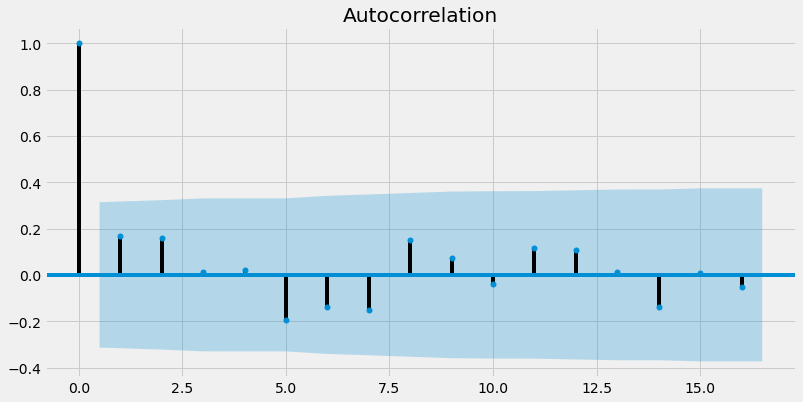

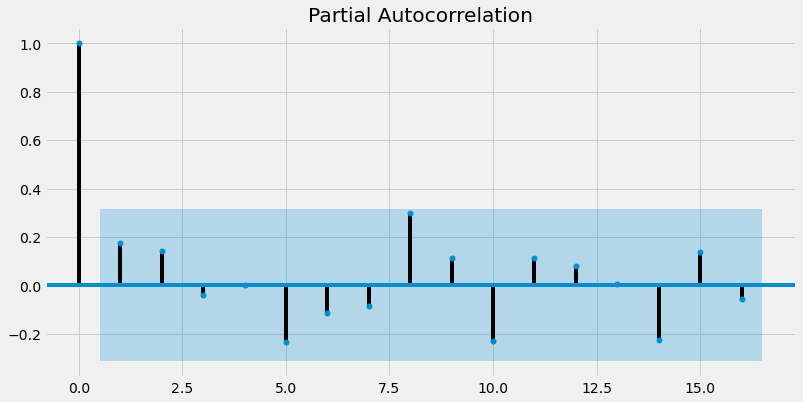

In [44]:
res = results.resid

fig = sm.graphics.tsa.plot_acf(res)
fig = sm.graphics.tsa.plot_pacf(res)

In [45]:
tes.fillna(value=0,inplace=True)

In [46]:
pred = results.predict(start='2017-12-31',end=te_end,exog=tes[regressors])

In [47]:
pred_edt = pred * df_biskrem_all['2017-12-31':]['No_of_days']

In [48]:
rms = sqrt(mean_squared_error(df_biskrem_all['2017-12-31':'2020-01-31']['Sales_vol'],pred_edt['2017-12-31':'2020-01-31']))
rms

30.59437207866157

In [49]:
rms = sqrt(mean_squared_error(df_biskrem_all['2020-06-30':'2020-08-31']['Sales_vol'],pred_edt['2020-06-30':'2020-08-31']))
rms

52.457130029143144

In [50]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [51]:
mape(df_biskrem_agg['2017-12-31':'2020-01-31']['Sales_vol'],pred_edt['2017-12-31':'2020-01-31'])

3.6711094282013255

In [52]:
mape(df_biskrem_agg['2020-06-30':'2020-08-31']['Sales_vol'],pred_edt['2020-06-30':'2020-08-31'])

7.874366919998188

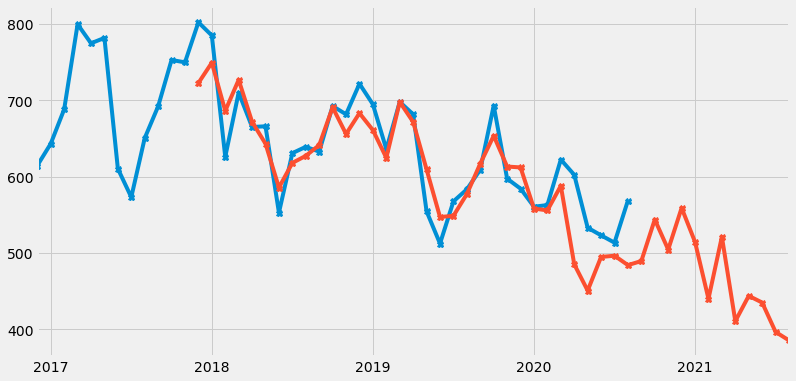

In [53]:
df_biskrem_agg['Sales_vol'].plot(marker="X")
pred_edt.plot(marker="X")
#pred.predicted_mean.plot(marker="X")

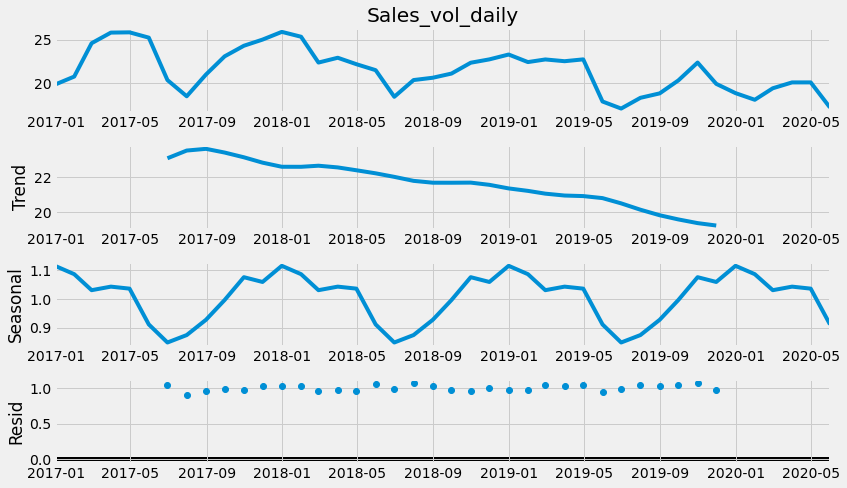

In [54]:
rcParams['figure.figsize'] = 12, 7

decomposition = sm.tsa.seasonal_decompose(tra_pand['Sales_vol_daily'].dropna(),model='multiplicative')
fig = decomposition.plot()

In [55]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

regressors = ['No_of_days','Actual_Holiday_Ratio','School_Day_Ratio','Ramadan_Ratio','Pandemic','GRP_30']


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(tra_pand['Sales_vol_daily'],
                                            tra_pand[regressors],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            trend='t')

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:156.42002927666462
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:664.3368067291228
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:78.25227269375691
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:129.52359345686966
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:73.40227958389869
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:23.843554515634878
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:94.7525006606088
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:24.477905439079475
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:20.0
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:112.20417338992665
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:117.79928756337463
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:81.3754301460772
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:78.44056797051175
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:75.19188408095167
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:34.45749790470729
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:24.76603882030234
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:26.447146826275173
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:22.0
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 

In [56]:
#(1, 1, 2)x(1, 0, 0, 12)
#
#
#

regressors = ['No_of_days','Actual_Holiday_Ratio','School_Day_Ratio','Ramadan_Ratio','Pandemic','GRP_30']

mod = sm.tsa.statespace.SARIMAX(tra_pand['Sales_vol_daily'],
                                tra_pand[regressors],
                                order=(1, 1, 2),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                trend='t')

results = mod.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                     Sales_vol_daily   No. Observations:                   42
Model:             SARIMAX(1, 1, 2)x(1, 0, [], 12)   Log Likelihood                 -40.087
Date:                             Tue, 06 Oct 2020   AIC                            104.175
Time:                                     14:00:55   BIC                            120.161
Sample:                                 12-31-2016   HQIC                           109.062
                                      - 05-31-2020                                         
Covariance Type:                               opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
drift                   -0.0024      0.004     -0.662      0.508      -0.010       0.005
No_of_days               0.2286      0.205      1.116      0.264      -0.173       0.630
Actual_Holiday_Ratio    -0.3743      6.343     -0.059      0.953     -12.806      12.057
School_Day_Ratio         3.5060      1.630      2.151      0.031       0.312       6.700
Ramadan_Ratio           -2.9001      1.080     -2.684      0.007      -5.017      -0.783
Pandemic                 0.7806      3.428      0.228      0.820      -5.938       7.499
GRP_30                   0.0012      0.002      0.561      0.575      -0.003       0.005
ar.L1                    0.5004      0.612      0.817      0.414      -0.699       1.700
ma.L1                   -1.0131      1.920     -0.528      0.598      -4.776       2.749
ma.L2                   -0.0096      0.529     -0.018      0.985      -1.047       1.027
ar.S.L12                -0.1759      0.303     -0.580      0.562      -0.770       0.418
sigma2                   0.9144      1.965      0.465      0.642      -2.938       4.766
===================================================================================
Ljung-Box (Q):                       35.23   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.13   Prob(JB):                         0.90
Heteroskedasticity (H):               1.52   Skew:                            -0.19
Prob(H) (two-sided):                  0.54   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
results.resid.describe()

count    42.000000
mean      0.201346
std       2.118758
min      -2.961365
25%      -0.641598
50%      -0.079468
75%       0.666273
max      10.360333
dtype: float64

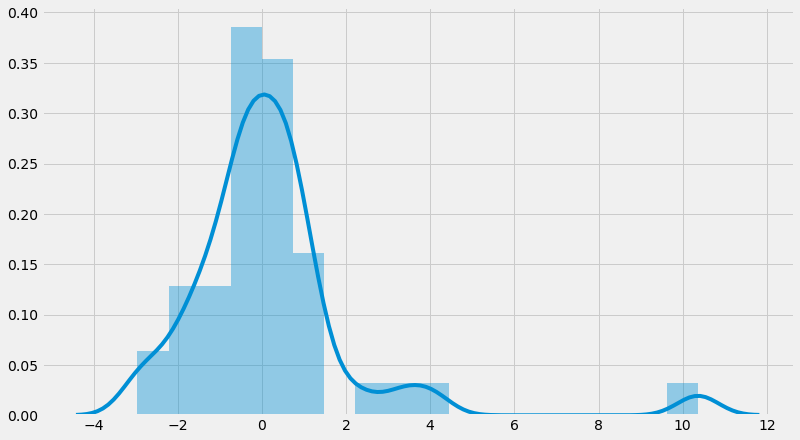

In [58]:
sns.distplot(results.resid)

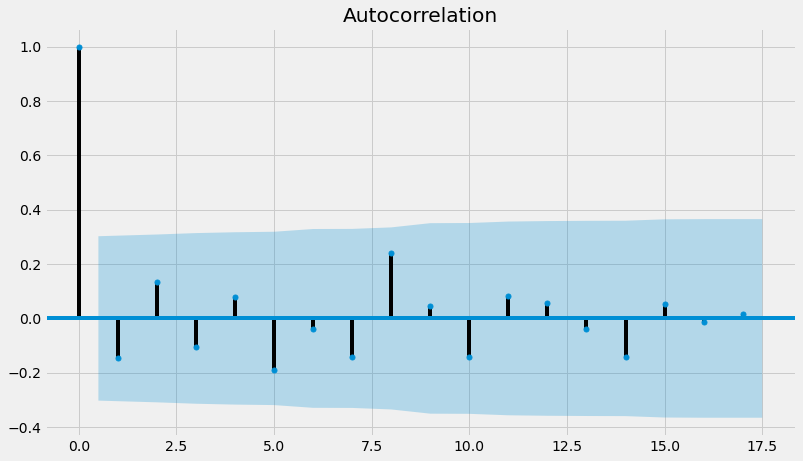

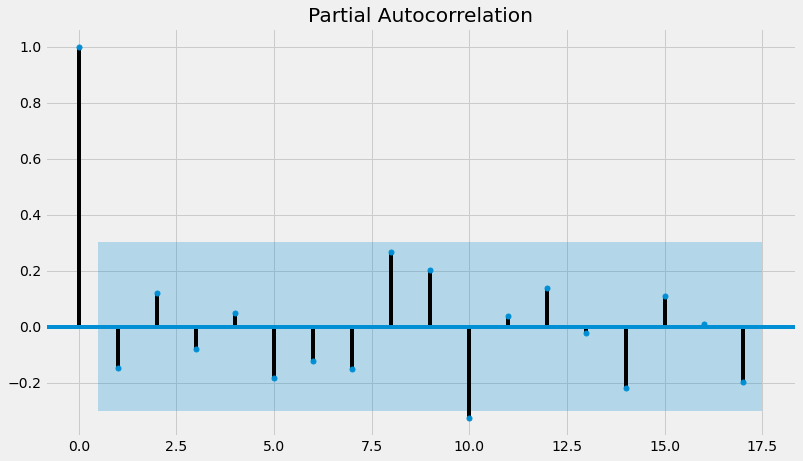

In [59]:
res = results.resid

fig = sm.graphics.tsa.plot_acf(res)
fig = sm.graphics.tsa.plot_pacf(res)

In [60]:
pred_pand = results.predict(start='2017-12-31',end=te_end_pand,exog=tes_pand[regressors])

In [61]:
pred_pand_edt = pred_pand * df_biskrem_all['2017-12-31':]['No_of_days']

In [62]:
rms = sqrt(mean_squared_error(df_biskrem_all['2017-12-31':'2020-05-31']['Sales_vol'],pred_pand_edt['2017-12-31':'2020-05-31']))
rms

31.325741049816596

In [63]:
rms = sqrt(mean_squared_error(df_biskrem_all['2020-06-30':'2020-08-31']['Sales_vol'],pred_pand_edt['2020-06-30':'2020-08-31']))
rms

35.55450037764199

In [64]:
mape(df_biskrem_all['2017-12-31':'2020-05-31']['Sales_vol'],pred_pand_edt['2017-12-31':'2020-05-31'])

3.8975773571595775

In [65]:
mape(df_biskrem_all['2020-06-30':'2020-08-31']['Sales_vol'],pred_pand_edt['2020-06-30':'2020-08-31'])

6.541978143782985

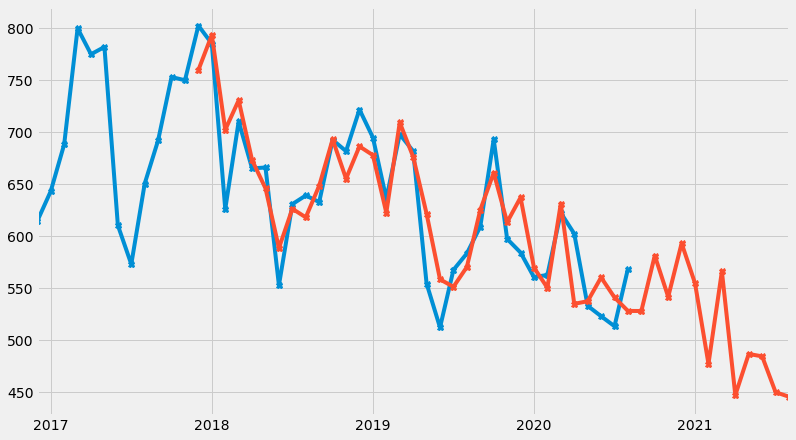

In [66]:
df_biskrem_agg['Sales_vol'].plot(marker="X")

pred_pand_edt.plot(marker="X")
#pred.predicted_mean.plot(marker="X")